100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

torch.Size([50000, 3, 32, 32])

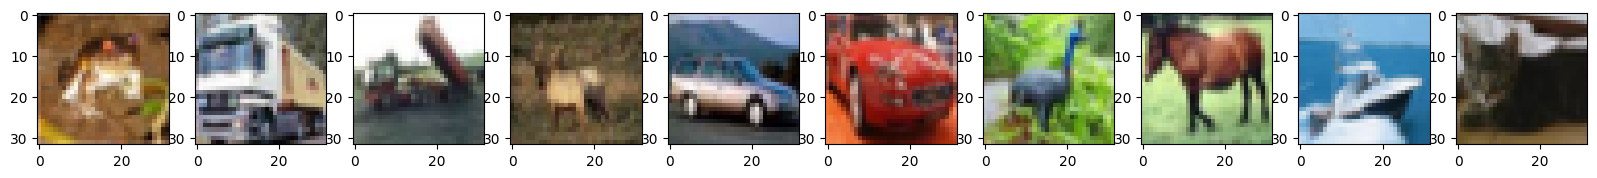

In [2]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets
from torchvision.models import resnet18

CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

len(y_train), len(y_test)

X_train.min(), X_train.max()

X_train /= 255.
X_test /= 255.

CIFAR_train.classes

import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

X_train.shape, y_train.shape

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

X_train.shape

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ResNet18 = resnet18(pretrained=False, num_classes=10).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    batch_size = 70

    test_accuracy_history = []
    test_loss_history = []
    train_accuracy_history = []
    train_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        with torch.no_grad():
          test_preds = net.forward(X_test)
          test_loss_history.append(loss(test_preds, y_test).data.cpu())

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
          test_accuracy_history.append(accuracy)

          train_preds = net.forward(X_train)
          train_loss_history.append(loss(train_preds, y_train).data.cpu())

          accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().data.cpu()
          train_accuracy_history.append(accuracy)

          print(f'Эпоха №{epoch + 1}, точность на тестовых данных: {test_accuracy_history[-1]}, точность на тренеровочных данных: {train_accuracy_history[-1]}')
    print('---------------')
    return test_accuracy_history, test_loss_history, train_accuracy_history, train_loss_history

accuracies_test = {}
losses_test = {}
accuracies_train = {}
losses_train = {}

In [9]:
accuracies_test['ResNet18'], losses_test['ResNet18'], accuracies_train['ResNet18'], losses_train['ResNet18'] = \
    train(ResNet18, X_train, y_train, X_test, y_test)

Эпоха №1, точность на тестовых данных: 0.5622000098228455, точность на тренеровочных данных: 0.5816599726676941
Эпоха №2, точность на тестовых данных: 0.5521999597549438, точность на тренеровочных данных: 0.5732799768447876
Эпоха №3, точность на тестовых данных: 0.6266999840736389, точность на тренеровочных данных: 0.6735999584197998
Эпоха №4, точность на тестовых данных: 0.6672999858856201, точность на тренеровочных данных: 0.7339199781417847
Эпоха №5, точность на тестовых данных: 0.6685999631881714, точность на тренеровочных данных: 0.7423399686813354
Эпоха №6, точность на тестовых данных: 0.7315999865531921, точность на тренеровочных данных: 0.8392599821090698
Эпоха №7, точность на тестовых данных: 0.6983999609947205, точность на тренеровочных данных: 0.8184599876403809
Эпоха №8, точность на тестовых данных: 0.7242000102996826, точность на тренеровочных данных: 0.873699963092804
Эпоха №9, точность на тестовых данных: 0.7372999787330627, точность на тренеровочных данных: 0.8965999484

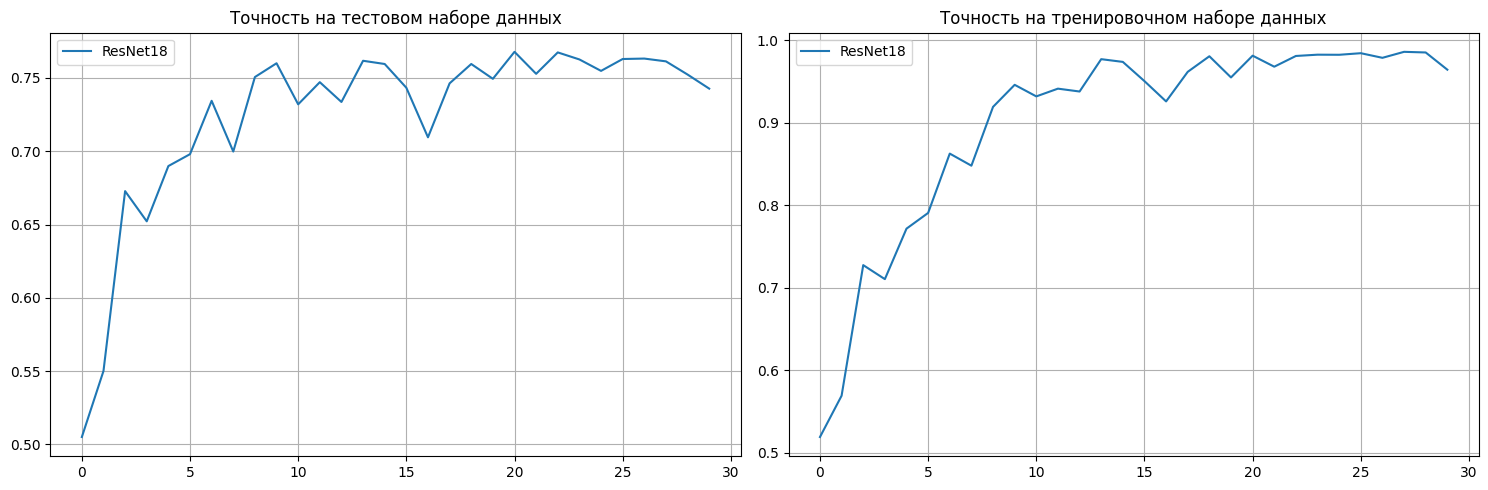

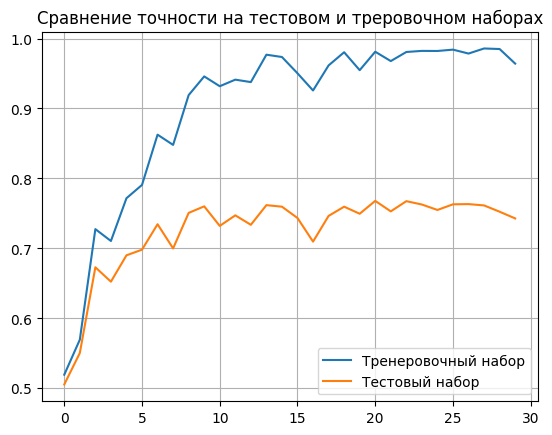

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Точность на тестовом наборе данных')
for experiment_id in accuracies_test.keys():
    axes[0].plot(accuracies_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Точность на тренировочном наборе данных')
for experiment_id in accuracies_train.keys():
    axes[1].plot(accuracies_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение точности на тестовом и треровочном наборах')
plt.plot(accuracies_train["ResNet18"], label="Тренеровочный набор")
plt.plot(accuracies_test["ResNet18"], label="Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()

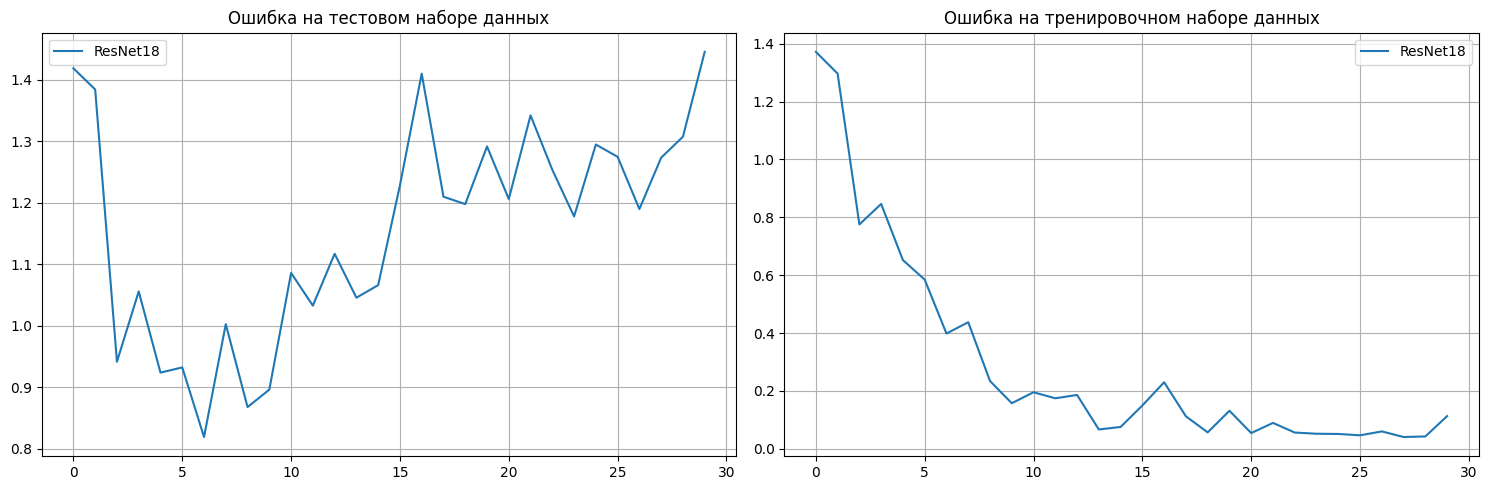

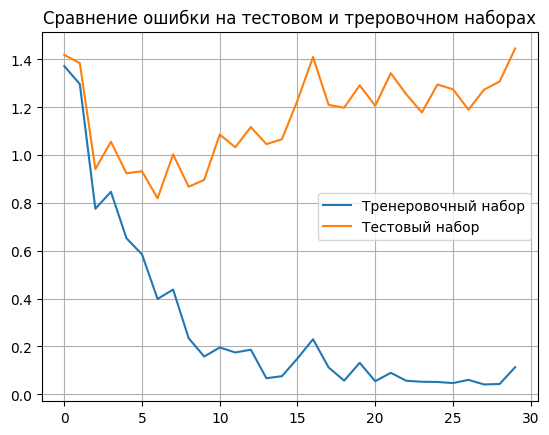

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Ошибка на тестовом наборе данных')
for experiment_id in losses_test.keys():
    axes[0].plot(losses_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Ошибка на тренировочном наборе данных')
for experiment_id in losses_train.keys():
    axes[1].plot(losses_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение ошибки на тестовом и треровочном наборах')
plt.plot(losses_train["ResNet18"], label="Тренеровочный набор")
plt.plot(losses_test["ResNet18"], label="Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import torch

class BasicBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.act1 = torch.nn.ReLU(inplace=True)

        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)  # Применение downsample к identity

        x += identity
        x = self.act1(x)
        return x


class ResNet20(torch.nn.Module):
    def __init__(self):
        super(ResNet20, self).__init__()
        self.in_channels = 16  # Начальное количество каналов

        self.conv1 = torch.nn.Conv2d(3, self.in_channels, kernel_size=3, padding=1, bias=False)   # Результат: 32x32x16
        self.bn1 = torch.nn.BatchNorm2d(self.in_channels)
        self.act1 = torch.nn.ReLU(inplace=True)

        # Стек блоков ResNet
        self.layer1 = self._make_layer(BasicBlock, self.in_channels, 3)   # 16 каналов
        self.layer2 = self._make_layer(BasicBlock, 32, 3, stride=2)    # Увеличиваем количество до 32
        self.layer3 = self._make_layer(BasicBlock, 64, 3, stride=2)    # Увеличиваем количество до 64

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Адаптивный пулинг до 1x1
        self.fc = torch.nn.Linear(64, 10)  # 10 классов для CIFAR10

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))  # Передаем правильные каналы
        self.in_channels = out_channels  # Обновляем количество канала после первого блока
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))  # Остальные блоки

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



In [6]:
accuracies_test['ResNet20'], losses_test['ResNet20'], accuracies_train['ResNet20'], losses_train['ResNet20'] = \
    train(ResNet20(), X_train, y_train, X_test, y_test)

Эпоха №1, точность на тестовых данных: 0.48159998655319214, точность на тренеровочных данных: 0.4870399832725525
Эпоха №2, точность на тестовых данных: 0.6848999857902527, точность на тренеровочных данных: 0.703279972076416
Эпоха №3, точность на тестовых данных: 0.7188999652862549, точность на тренеровочных данных: 0.7434799671173096
Эпоха №4, точность на тестовых данных: 0.7561999559402466, точность на тренеровочных данных: 0.7967000007629395
Эпоха №5, точность на тестовых данных: 0.7333999872207642, точность на тренеровочных данных: 0.7765799760818481
Эпоха №6, точность на тестовых данных: 0.7820000052452087, точность на тренеровочных данных: 0.8392999768257141
Эпоха №7, точность на тестовых данных: 0.7820999622344971, точность на тренеровочных данных: 0.8543199896812439
Эпоха №8, точность на тестовых данных: 0.8007999658584595, точность на тренеровочных данных: 0.8816199898719788
Эпоха №9, точность на тестовых данных: 0.7884999513626099, точность на тренеровочных данных: 0.871559977

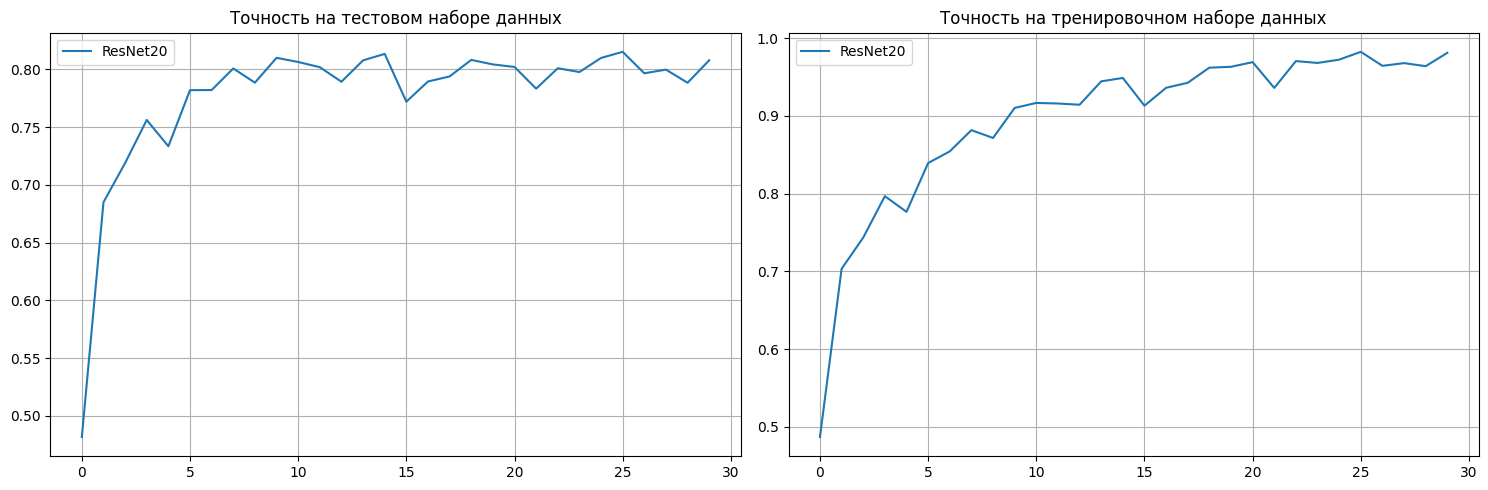

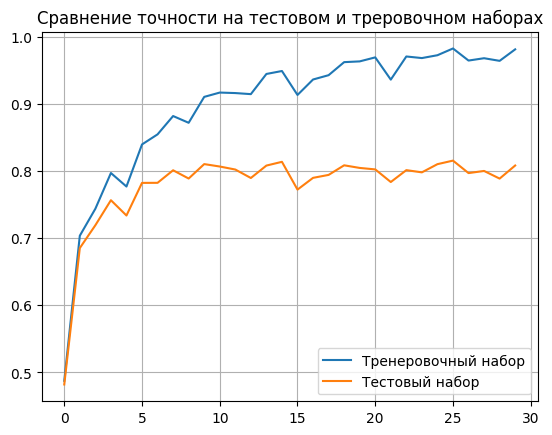

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Точность на тестовом наборе данных')
for experiment_id in accuracies_test.keys():
    axes[0].plot(accuracies_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Точность на тренировочном наборе данных')
for experiment_id in accuracies_train.keys():
    axes[1].plot(accuracies_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение точности на тестовом и треровочном наборах')
plt.plot(accuracies_train["ResNet20"], label="Тренеровочный набор")
plt.plot(accuracies_test["ResNet20"], label="Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()

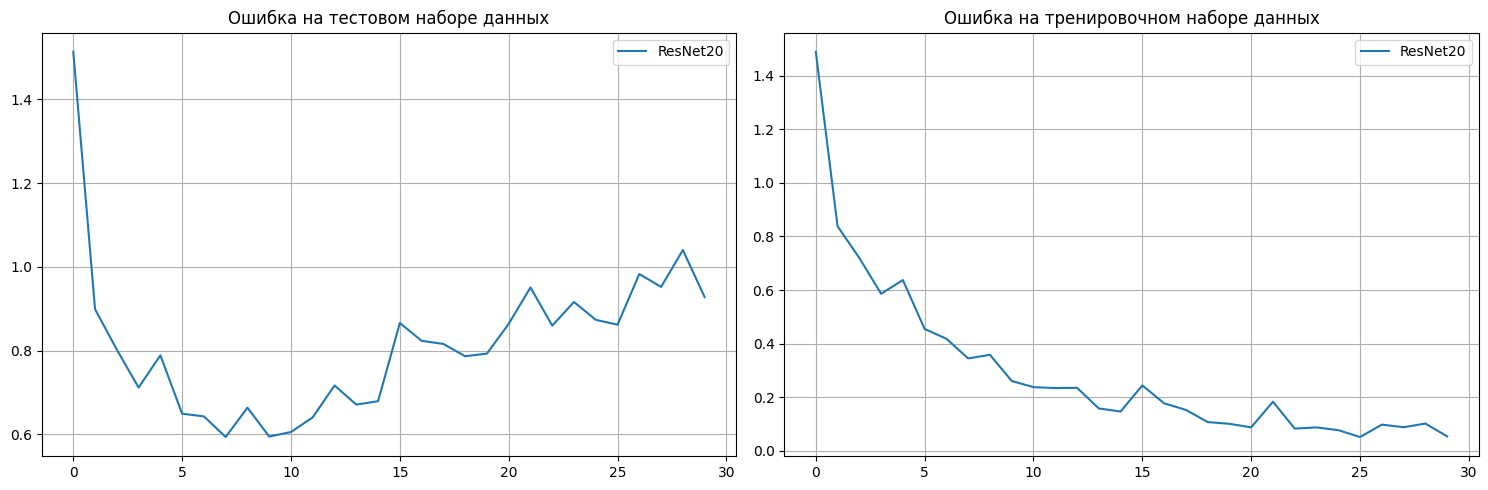

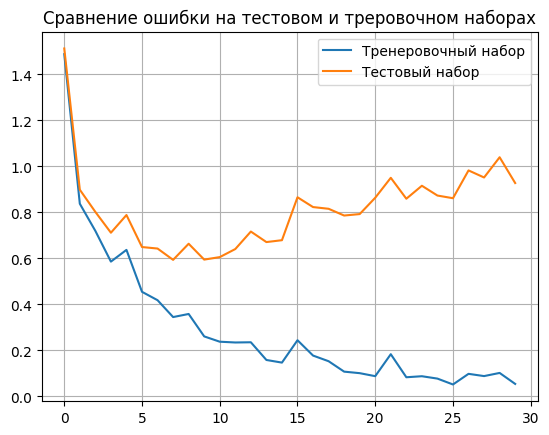

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Ошибка на тестовом наборе данных')
for experiment_id in losses_test.keys():
    axes[0].plot(losses_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Ошибка на тренировочном наборе данных')
for experiment_id in losses_train.keys():
    axes[1].plot(losses_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение ошибки на тестовом и треровочном наборах')
plt.plot(losses_train["ResNet20"], label="Тренеровочный набор")
plt.plot(losses_test["ResNet20"], label="Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()

СРАВНЕНИЕ РЕЗУЛЬТАТОВ НЕЙРОННЫХ СЕТЕЙ

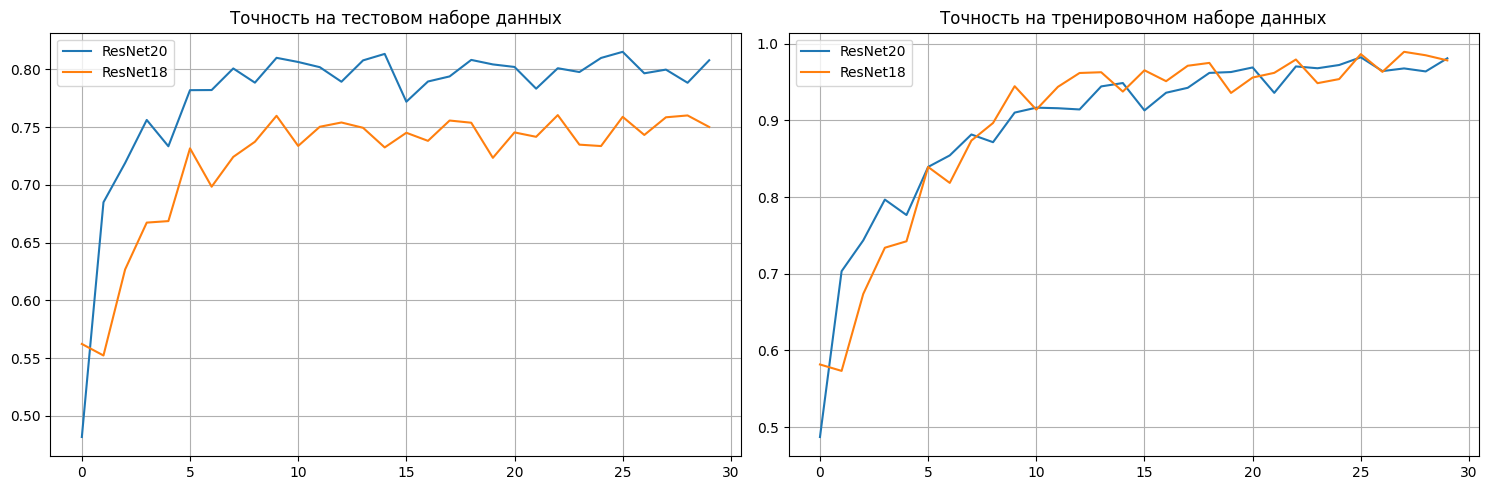

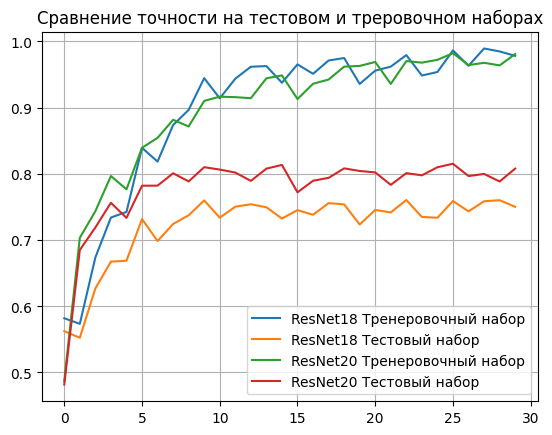

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Точность на тестовом наборе данных')
for experiment_id in accuracies_test.keys():
    axes[0].plot(accuracies_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Точность на тренировочном наборе данных')
for experiment_id in accuracies_train.keys():
    axes[1].plot(accuracies_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение точности на тестовом и треровочном наборах')
plt.plot(accuracies_train["ResNet18"], label="ResNet18 Тренеровочный набор")
plt.plot(accuracies_test["ResNet18"], label="ResNet18 Тестовый набор")
plt.plot(accuracies_train["ResNet20"], label="ResNet20 Тренеровочный набор")
plt.plot(accuracies_test["ResNet20"], label="ResNet20 Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()

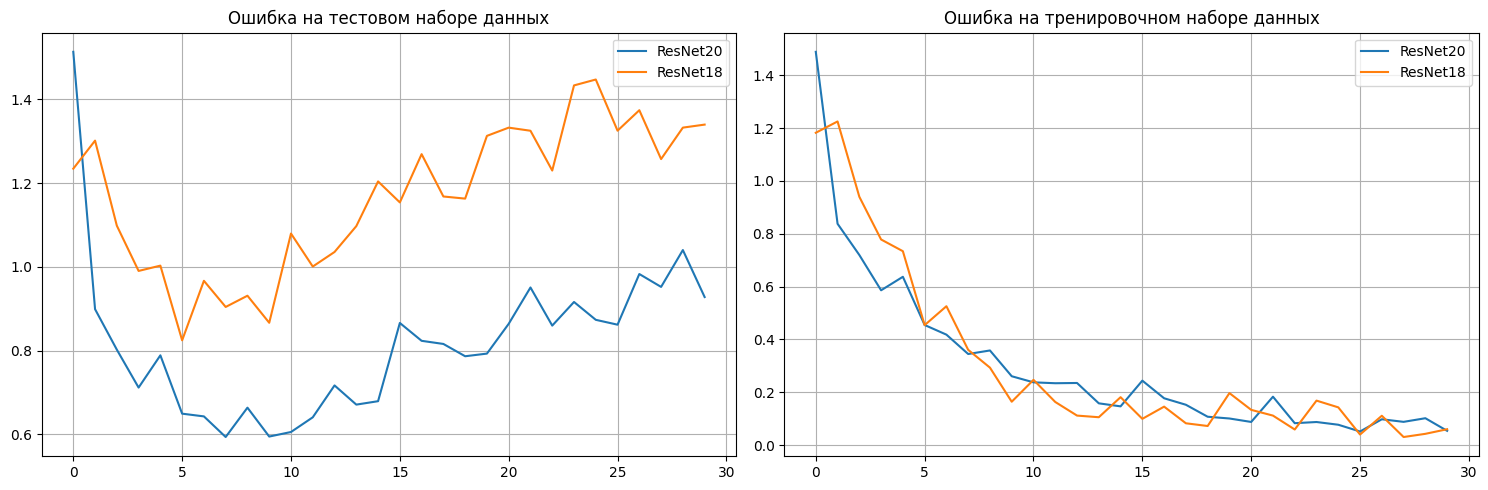

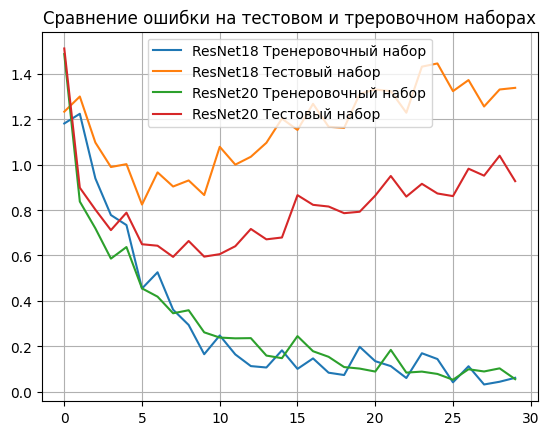

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Ошибка на тестовом наборе данных')
for experiment_id in losses_test.keys():
    axes[0].plot(losses_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Ошибка на тренировочном наборе данных')
for experiment_id in losses_train.keys():
    axes[1].plot(losses_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение ошибки на тестовом и треровочном наборах')
plt.plot(losses_train["ResNet18"], label="ResNet18 Тренеровочный набор")
plt.plot(losses_test["ResNet18"], label="ResNet18 Тестовый набор")
plt.plot(losses_train["ResNet20"], label="ResNet20 Тренеровочный набор")
plt.plot(losses_test["ResNet20"], label="ResNet20 Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()